In [44]:
import numpy as np
from scipy.io.wavfile import write, read
from scipy.signal import chirp 
import sounddevice as sd
import matplotlib.pyplot as plt

def gen_chirp(T, save = False, play = False, form = 'logarithmic', repititions = 1):
    fs = 44100
    t = np.arange(0, int(T*fs))/fs
    w = chirp(t, 20, T, 20000, method = form)
    if repititions > 1:
        w = np.tile(w, repititions)
    if save == True:
        write('chirp_{}_{}_{}.wav'.format(form, 20, 20000), fs, w)
    if play == True:
        sd.play(w, fs, blocking = True)
    return w

def record(title = 'test', duration = 5, save = False, plot = False):
    fs = 44100
    r = sd.rec(int(duration*fs), samplerate = fs, channels = 1, blocking = True).flatten()
    if save  == True:
        write("{}.wav".format(title), fs, r)
    if plot == True:
        plt.plot(np.arange(0, int(duration*fs)), r)
        plt.show()
    return r

def conv(r, w):
    fs = 44100
    w_inv = np.flip(w)
    convolution = np.convolve(r,w_inv)
    t = np.arange(0, len(convolution))/fs
    plt.figure(figsize = (5,5))
    plt.plot(t, np.abs(convolution))
    plt.show()
    return np.abs(convolution)
    
def read_wav(filename):
    fs, data = read(filename)
    return data

In [45]:
%matplotlib notebook

<IPython.core.display.Javascript object>


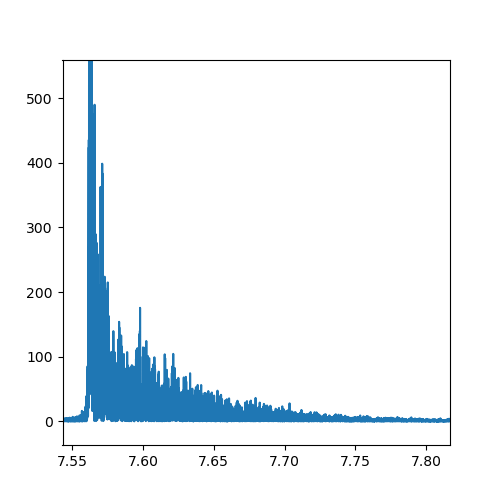

array([0.00000000e+00, 0.00000000e+00, 2.92249939e-05, ...,
       3.05175781e-05, 0.00000000e+00, 0.00000000e+00])

In [46]:
# First test quadratic:
w = gen_chirp(5, form = 'quadratic')
r = record(duration = 20)
c = conv(r,w)

<IPython.core.display.Javascript object>


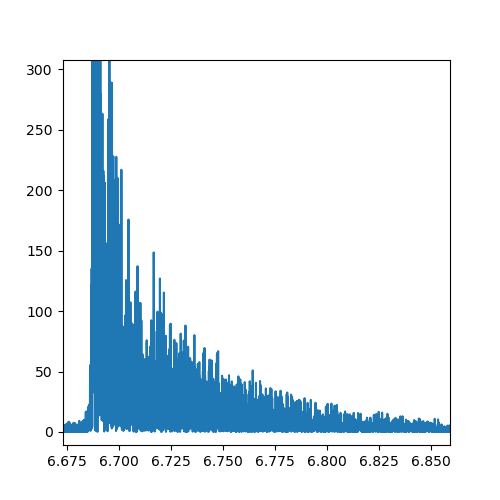

In [47]:
# Test logarithmic:
w = gen_chirp(5, form = 'logarithmic')
r = record(duration = 15)
c = conv(r,w)

<IPython.core.display.Javascript object>


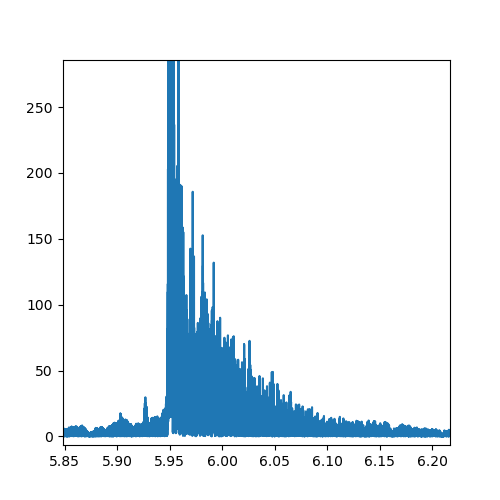

In [48]:
# Test Linear:
w = gen_chirp(5, form = 'linear')
r = record(duration = 15)
c = conv(r,w)

<IPython.core.display.Javascript object>


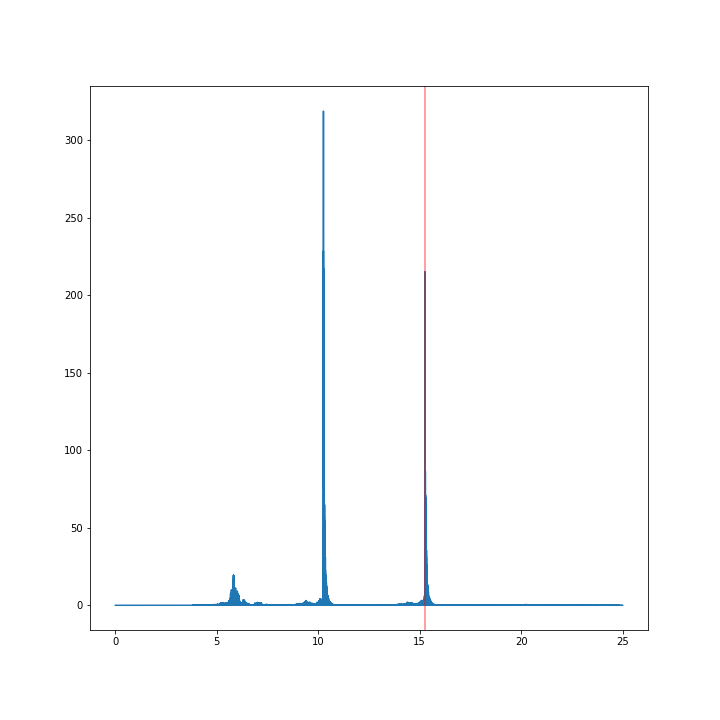

we are 1 samples too late


In [55]:
# We can see the linear performes the best. Now we try to use the first peak to locate the second peaks
fs = 44100
c = np.abs(c)
# Finding the highest peak:
c_max_index_1 = c.argmax()
x = c.copy()
x[c_max_index_1-2000:c_max_index_1+2000] = 0
# Finding the second highest peak
c_max_index_2 = x.argmax()
if c_max_index_2 > c_max_index_1:
    prediction = c_max_index_1 + 5*fs
else:
    prediction = c_max_index_1 - 5*fs
    
t = np.arange(0, len(c))/fs
plt.figure(figsize = (10,10))
plt.plot(t, np.abs(c), label = '')
plt.axvline(x=prediction/fs, c = 'r', alpha = 0.5)
plt.show()
print('we are {} samples too late'.format(prediction-c_max_index_2))

<IPython.core.display.Javascript object>


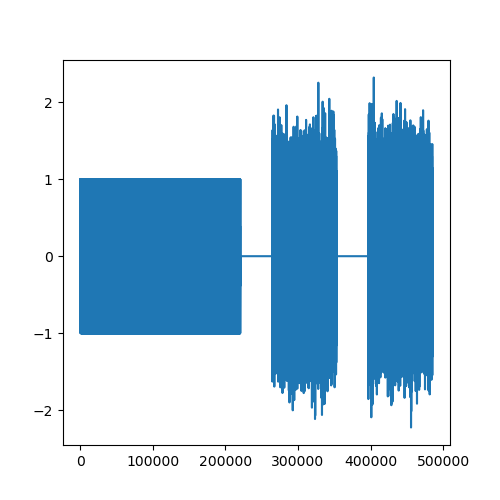

In [17]:
fs = 44100
method = 'linear'
# Now we send a chirp, a pause, white noise, pause, white noise
w = gen_chirp(5, form = method) #5 seconds
#1 second pause:
pause = np.zeros(fs) #1 second
noise_1 = 0.5*np.random.randn(2*fs) #2 seconds
noise_2 = 0.5*np.random.randn(2*fs) #2 seconds

signal = np.concatenate((w,pause,noise_1,pause,noise_2))
plt.figure(figsize = (5,5))
t = np.linspace()
plt.plot(signal)
plt.show()

In [19]:
write('chirp+noise_{}_{}_{}.wav'.format(method, 20, 20000), fs, signal)

<IPython.core.display.Javascript object>


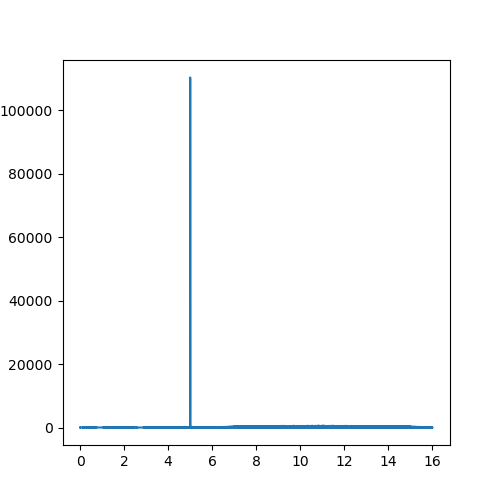

In [20]:
#expected result of conv
c = conv(signal,w)

<IPython.core.display.Javascript object>


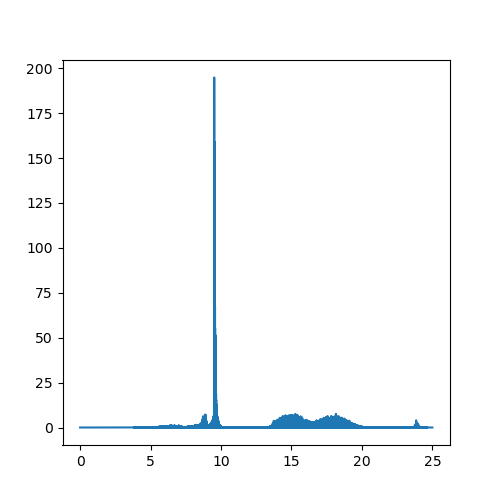

<IPython.core.display.Javascript object>


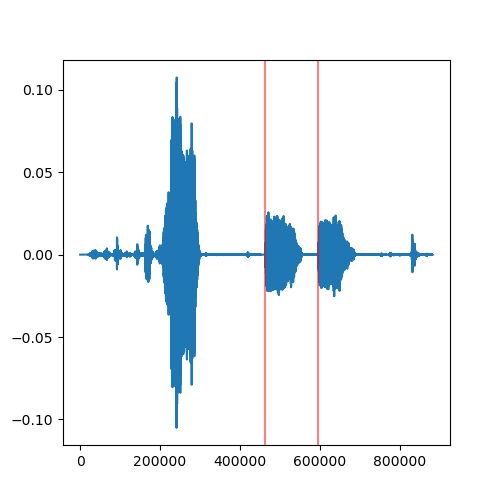

In [24]:
r = record(duration = 20)
c = conv(r, w)
c_max_time = c.argmax()
n1_start_index = c_max_time - 5*fs + (5+1)*fs
n2_start_index = c_max_time - 5*fs + (5+1+2+1)*fs
plt.figure(figsize = (5,5))
plt.plot(r)
plt.axvline(x=n1_start_index, c = 'r', alpha = 0.5)
plt.axvline(x=n2_start_index, c = 'r', alpha = 0.5)
plt.show()

<IPython.core.display.Javascript object>


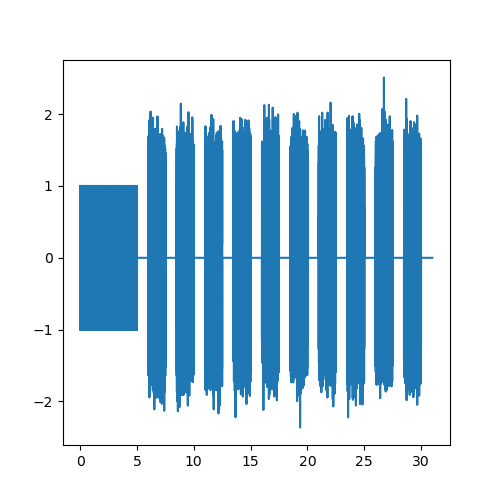

In [32]:
def noise_block(T):
    fs = 44100
    return 0.5*np.random.randn(int(T*fs))

T = 1.5
pilot_tone = gen_chirp(5, form = 'linear')
pause = np.zeros(fs)
signal = np.concatenate((pilot_tone, pause))

for i in range(10):
    noise = noise_block(T)
    signal = np.concatenate((signal, noise, pause))

t = np.linspace(0,len(signal)/fs, len(signal))
plt.figure(figsize = (5,5))
plt.plot(t, signal)
plt.show()

In [30]:
write('chirp+10_noise_{}_{}_{}.wav'.format(method, 20, 20000), fs, signal)

385875


<IPython.core.display.Javascript object>


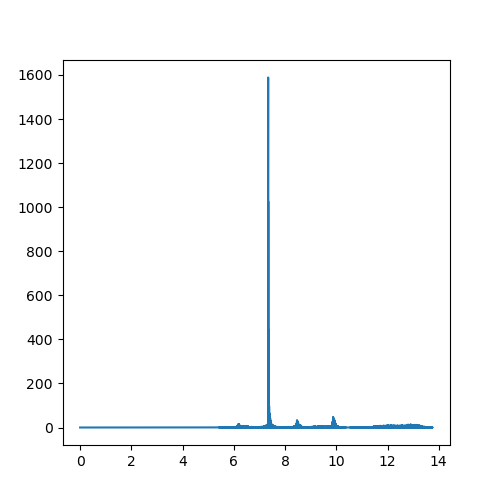

<IPython.core.display.Javascript object>


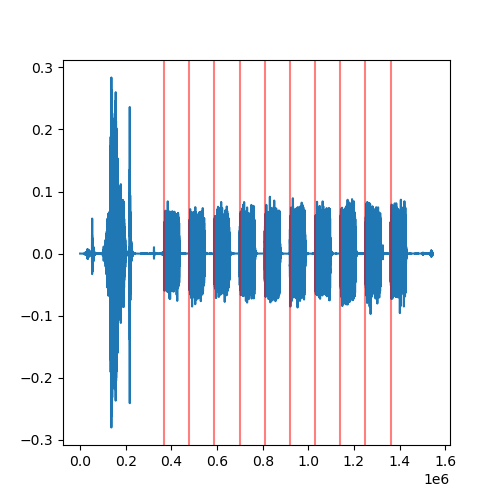

In [42]:
r = record(duration = 35)
L = int(len(r)/4)
print(L)
c = conv(r[:L], pilot_tone)
t = np.linspace(0, len(c)/fs, len(c))
c_max_index = c.argmax()
plt.figure(figsize = (5,5))
plt.plot(t, r)
for i in range(10):
    start_index = c_max_index + (i+1)*fs + i*fs*1.5
    plt.axvline(x=start_index, c = 'r', alpha = 0.5)
plt.show()